In [1]:
import pandas as pd
from ete3 import NCBITaxa, TreeStyle, AttrFace, TextFace

In [2]:
ncbi = NCBITaxa()

In [3]:
df = pd.read_csv("../all_datasets.csv")
all_tax_ids = df.loc[~pd.isna(df.tax_id), "tax_id"].astype(int).to_list()
all_tax_ids[:10]

[40324, 28197, 48296, 158851, 820, 147645, 548, 630, 1351, 293]

In [4]:
tree = ncbi.get_topology(all_tax_ids, intermediate_nodes=True)

In [5]:
# custom layout: adds "rank" on top of branches, and sci_name as tip names
def my_layout(node):
    #if getattr(node, "rank", None):
    #    rank_face = AttrFace("rank", fsize=7, fgcolor="black")
    #    node.add_face(rank_face, column=0, position="branch-top")
    if node.is_leaf():
        sciname_face = AttrFace("sci_name", fsize=12, fgcolor="black")
        sciname_face.margin_left = 5
        #node.add_face(sciname_face, column=0, position="branch-right")
        node.add_face(sciname_face, column=0, position="aligned")
        #taxid_face = TextFace(f" ({node.taxid})", fsize=9, fgcolor="steelblue")
        #node.add_face(taxid_face, column=1, position="branch-right")
    elif node.is_root():
        pass
    else:
        #rank_face = AttrFace("rank", fsize=7, fgcolor="black")
        #rank_face.hz_align = 2
        #node.add_face(rank_face, column=0, position="branch-top")
        sciname_face = AttrFace("sci_name", fsize=9, fgcolor="indianred")
        node.add_face(sciname_face, column=0, position="branch-top")
ts = TreeStyle()
ts.layout_fn = my_layout
ts.show_leaf_name = False
ts.optimal_scale_level = 'full' # 'mid'
ts.min_leaf_separation =0.2
#ts.complete_branch_lines_when_necessary = False
#ts.force_topology = True
#ts.allow_face_overlap = True
#ts.mode = 'c'

In [6]:
any_deleted = True
while any_deleted:
    any_deleted = False
    for node in tree.search_nodes():
        if not node.is_root():
            if ("group" in getattr(node, "sci_name", "") or
                "group" in getattr(node, "rank", "") or
                getattr(node, "rank", None) in ['subspecies', 'no rank', 'strain', 'tribe']):
                node.delete(prevent_nondicotomic=False)
                any_deleted = True
                break

In [7]:
rank_sizes = {'superkingdom':.4, 'phylum':.7, 'class':.8, 'order':.7, 'family':1., 'genus':.8, 'species':1.}
for node in tree.search_nodes():
    if node.is_root():
        node.dist = 0.1
    elif node.is_leaf():
        node.dist = 0.1
        if getattr(node, "rank", "") == 'genus':
            node.dist += rank_sizes['genus'] + .025
    else:
        node.dist = rank_sizes.get(getattr(node, "rank", ""), 1.0)
        for parent in node.iter_ancestors():
            break
        if (getattr(node, "rank", "") == 'species' and not getattr(parent, "rank", "") == 'genus'):
            node.dist += rank_sizes['genus'] + .025
        elif (getattr(node, "rank", "") == 'genus' and not getattr(parent, "rank", "") == 'family'):
            node.dist += rank_sizes['family'] + .025
        elif (getattr(node, "rank", "") == 'family' and not getattr(parent, "rank", "") == 'order'):
            node.dist += rank_sizes['order'] + .025
        elif (getattr(node, "rank", "") == 'order' and not getattr(parent, "rank", "") == 'class'):
            node.dist += rank_sizes['class'] + .025
        elif (getattr(node, "rank", "") == 'class' and not getattr(parent, "rank", "") == 'phylum'):
            node.dist += rank_sizes['phylum'] + .025

In [8]:
#tree.convert_to_ultrametric()

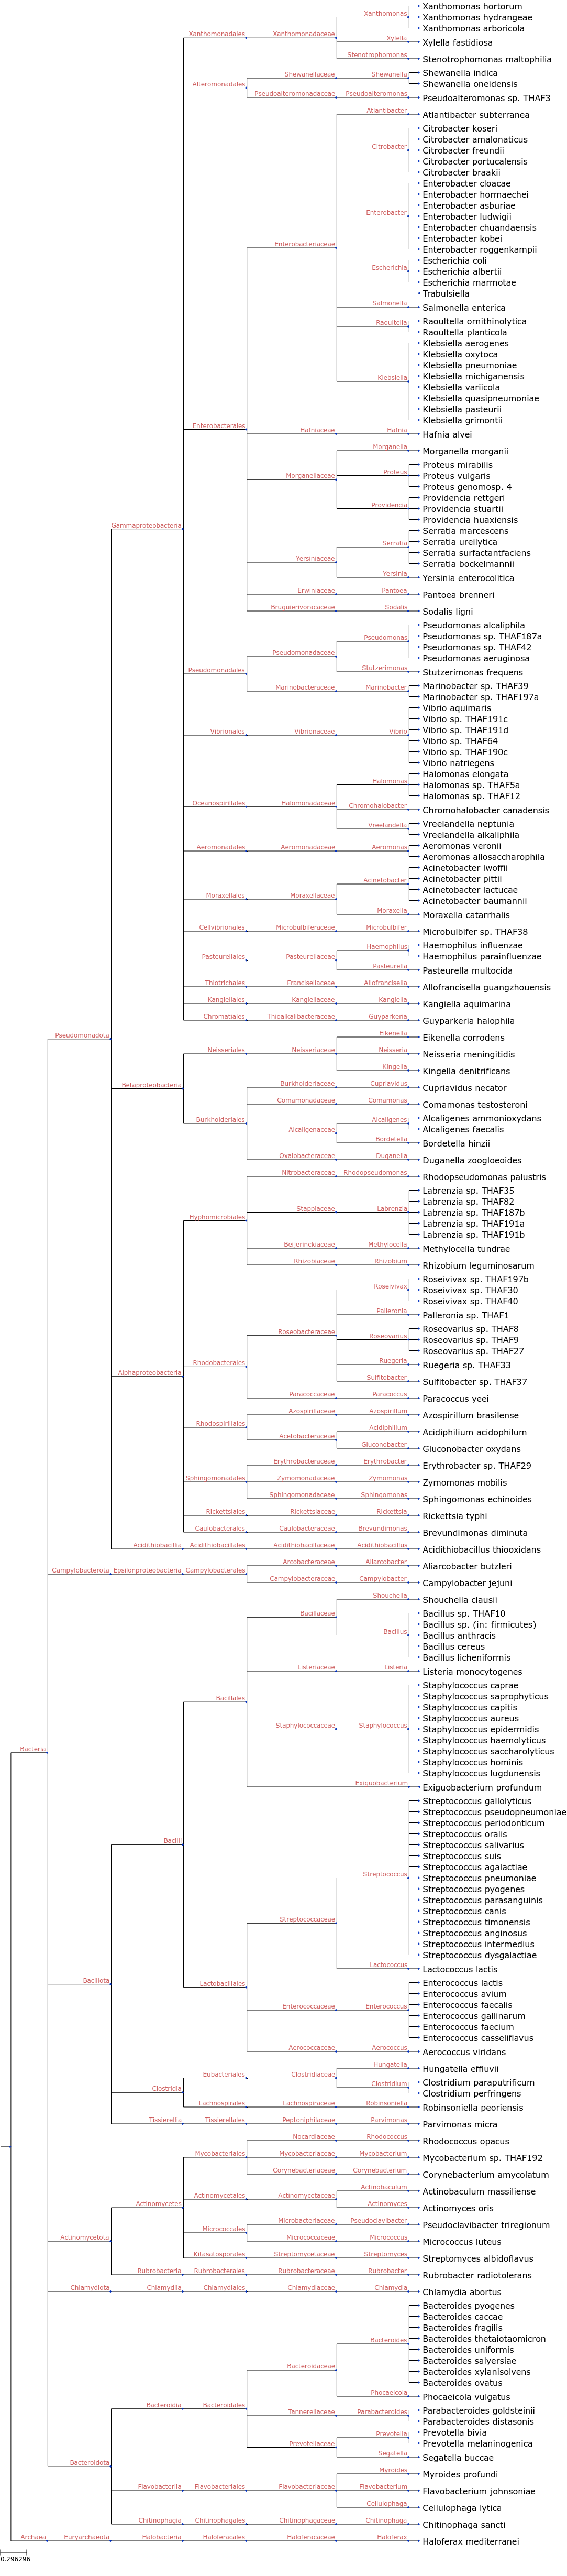

In [9]:
tree.render("%%inline", tree_style=ts)

In [10]:
len(tree.get_leaves())

196